In [1]:
import os
os.environ['GRB_LICENSE_FILE'] = '/home/victor/gurobi.lic'

import gurobipy as gp

from gurobipy import GRB, quicksum
print(gp.gurobi.version()) 
lic = gp.Env()
print(lic)

(12, 0, 2)
Set parameter Username
Set parameter LicenseID to value 2701230
Academic license - for non-commercial use only - expires 2026-08-30
<gurobipy.Env, Parameter changes: LicenseID=2701230>


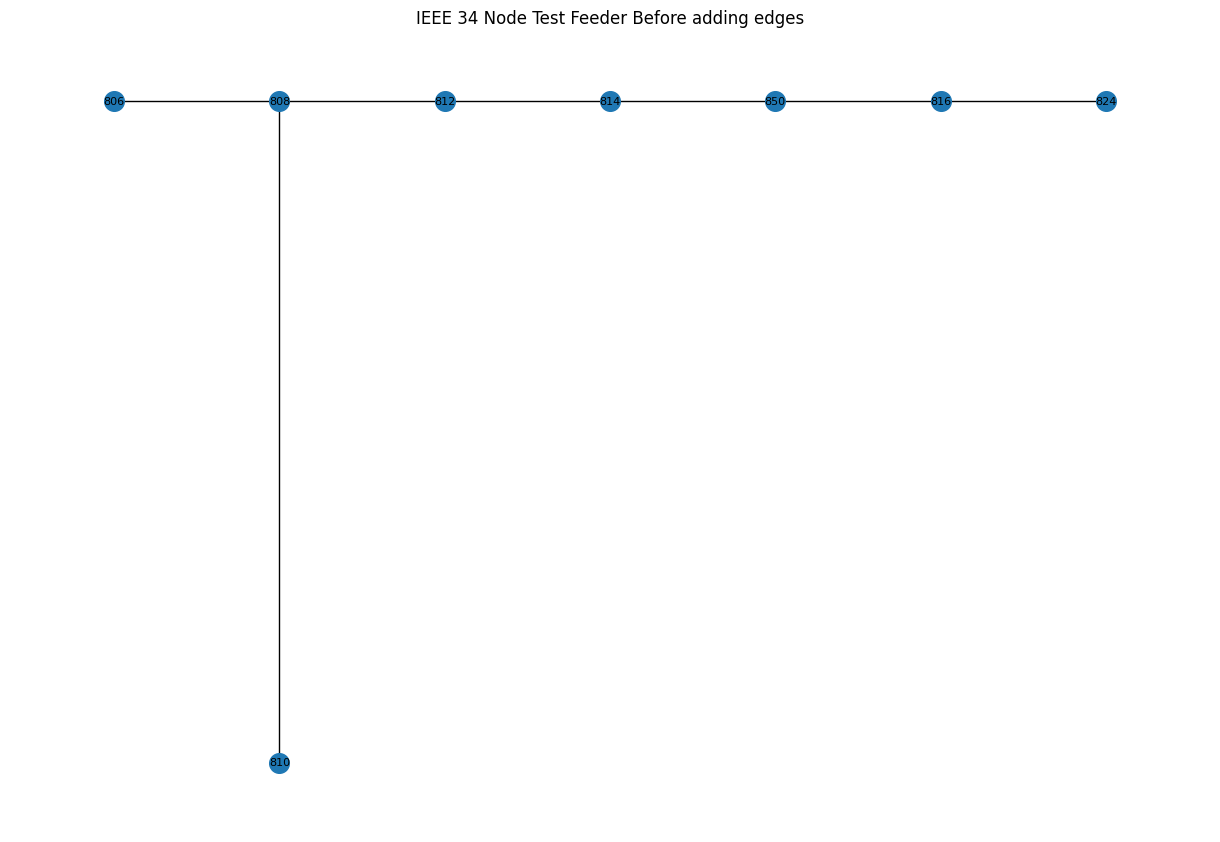

EdgesLenghts:  [(np.int64(806), np.int64(808), {'weight': np.int64(32230)}), (np.int64(808), np.int64(810), {'weight': np.int64(5804)}), (np.int64(808), np.int64(812), {'weight': np.int64(37500)}), (np.int64(812), np.int64(814), {'weight': np.int64(29730)}), (np.int64(814), np.int64(850), {'weight': np.int64(10)}), (np.int64(850), np.int64(816), {'weight': np.int64(310)}), (np.int64(816), np.int64(824), {'weight': np.int64(10210)})]


In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load feeder34 from excel file
df34 = pd.read_excel("./line_data_smaller_2.xls")
G34 = nx.Graph()
G123 = nx.Graph()
for _, row in df34.iterrows():
    from_node = row["Node A"]
    to_node = row["Node B"]
    length = row["Length(ft.)"]
    G34.add_edge(from_node, to_node, weight=length)

# Definir posições fixas (x,y) manualmente
pos = {
    800: (0, 0),
    802: (1, 0),
    806: (2, 0),
    808: (3, 0),
    810: (3, -1),
    812: (4, 0),
    814: (5, 0),
    816: (7, 0),
    818: (7, 1),
    820: (7, 2),
    822: (7, 3),
    824: (8, 0),
    826: (9, 0),
    828: (8, -4),
    850: (6, 0),
}


# Desenhar G34 
plt.figure(figsize=(12, 8))
nx.draw(G34, pos, with_labels=True, node_size=200, font_size=8)
plt.title("IEEE 34 Node Test Feeder Before adding edges")
plt.show()

print("EdgesLenghts: ", G34.edges(data=True))

In [11]:
def build_distance_matrix_with_virtuals(G):
    """
    Constrói matriz S_ij com distâncias de menor caminho:
      - índice 0 = nó virtual inicial
      - índice n_real+1 = nó virtual final
      - nós reais no meio, ordenados em ordem crescente
    """
    nodes = sorted(G.nodes())  
    n_real = len(nodes)
    n_total = n_real + 2

    # calcula todos os caminhos mínimos em termos de peso
    all_shortest = dict(nx.all_pairs_dijkstra_path_length(G, weight="weight"))
    df_paths = pd.DataFrame(all_shortest).astype(float)
    print(df_paths)
    # inicializa matriz
    S_ij = np.zeros((n_total, n_total), dtype=float)

    for i, ni in enumerate(nodes, start=1):
        for j, nj in enumerate(nodes, start=1):
            if i == j:
                S_ij[i, j] = 0
            else:
                # pega distância em pés
                dist_ft = all_shortest[ni][nj]
                # converte p/ km e depois p/ tempo em minutos
                dist_km = dist_ft * 0.0003048
                tempo_h = dist_km / 50.0
                tempo_min = tempo_h * 60
                S_ij[i, j] = tempo_min

    # nós virtuais: 0 no início e no fim
    S_ij[0, :] = 0
    S_ij[:, 0] = 0
    S_ij[-1, :] = 0
    S_ij[:, -1] = 0

    return S_ij, nodes


S_ij, nodes = build_distance_matrix_with_virtuals(G34)
df = pd.DataFrame(S_ij)
print(df)
print(nodes)

          806      808      810      812      814      850      816       824
806       0.0  32230.0  38034.0  69730.0  99460.0  99470.0  99780.0  109990.0
808   32230.0      0.0   5804.0  37500.0  67230.0  67240.0  67550.0   77760.0
810   38034.0   5804.0      0.0  43304.0  73034.0  73044.0  73354.0   83564.0
812   69730.0  37500.0  43304.0      0.0  29730.0  29740.0  30050.0   40260.0
814   99460.0  67230.0  73034.0  29730.0      0.0     10.0    320.0   10530.0
850   99470.0  67240.0  73044.0  29740.0     10.0      0.0    310.0   10520.0
816   99780.0  67550.0  73354.0  30050.0    320.0    310.0      0.0   10210.0
824  109990.0  77760.0  83564.0  40260.0  10530.0  10520.0  10210.0       0.0
     0          1          2          3          4          5          6  \
0  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1  0.0   0.000000  11.788445  13.911316  25.504445  36.378490  36.495533   
2  0.0  11.788445   0.000000   2.122871  13.716000  24.590045  24.7070

In [13]:
def CreateEdgesByDistance(G, near_node, distance):
    lengths = nx.single_source_dijkstra_path_length(G, near_node, weight='weight')
    ordered_nodes = sorted(lengths)
    arrayResponse = []
    arrayResponse.append(0)

    for node in ordered_nodes:
        dist_ft = lengths[node] + distance  # distância acumulada em ft

        # conversão p/ km
        dist_km = dist_ft * 0.0003048  

        # velocidade média = 50 km/h (ajuste se precisar)
        tempo_h = dist_km / 50.0  
        tempo_min = tempo_h * 60  

        arrayResponse.append(tempo_min)

    arrayResponse.append(0)
    return arrayResponse

d_mj = []
d_m1= CreateEdgesByDistance(G34, 806, 500) # Team 1
d_m2 = CreateEdgesByDistance(G34, 824, 2000) # Team 2
d_mj.append(d_m1)
d_mj.append(d_m2)
d_mj = pd.DataFrame(d_mj).astype(float)
print(d_mj)

     0          1          2          3          4          5          6  \
0  0.0   0.182880  11.971325  14.094196  25.687325  36.561370  36.678413   
1  0.0  40.961462  29.173018  31.295889  15.457018   4.582973   4.465930   

           7          8    9  
0  40.412822  36.565027  0.0  
1   0.731520   4.579315  0.0  


In [5]:
n_real = 8
n_virtual = 2
n_total = n_real + n_virtual
k = 2

# [0, 800, 802, 806, 808, 810, 812, 814, 816, 818, 820, 822, 824, 826, 828, 830, 832, 834, 836, 838, 840, 842, 844, 846, 848, 850, 852, 854, 856, 858, 860, 862, 864, 888, 890, 0]

p_j_dict = {
    0: 0,
    806: 1,
    808: 1,
    810: 1,
    812: 1,
    814: 3,
    816: 1,
    824: 1,
    850: 3,
    1000: 0,
}
#Function to list
p_j = list(p_j_dict.values())
t_j_dict = {
    0: 0,
    806: 5,
    808: 5,
    810: 5,
    812: 5,
    814: 30,
    816: 5,
    824: 5,
    850: 30,
    1000: 0,
}
t_j = list(t_j_dict.values())

q_jl = [[round(p / (l + 1), 2) for l in range(n_real+1)] for p in p_j]

In [6]:
m = gp.Model()

# Create variables
C_j = m.addVars(n_total, name='C_j', vtype=gp.GRB.CONTINUOUS, lb=0)
Y_ilm = m.addVars(n_total, n_total, k, name='Y_ilm', vtype=gp.GRB.BINARY)
X_ijm = m.addVars(n_total, n_total, k, name='X_ijm', vtype=gp.GRB.BINARY)
C_max = m.addVar(name='C_max', vtype=gp.GRB.CONTINUOUS, lb=0)

#Create objective function

# Z_p
Z_p = quicksum(q_jl[i][l] * Y_ilm[i, l, m]
               for i in range(n_real+1)
               for l in range(n_real+1)
               for m in range(k))

# TFT
# Parte 1: sequência das inspeções (i precede j)
flow_time = quicksum(
    (S_ij[i][j] + t_j[j]) * X_ijm[i, j, m]
    for i in range(n_real + 1)
    for j in range(1, n_real + 2)
    if i != j
    for m in range(k)
)

# Parte 2: deslocamento inicial da equipe m até o primeiro equipamento j
initial_travel = quicksum(
    d_mj[m][j] * Y_ilm[j, 1, m]
    for j in range(1, n_real + 2)
    for m in range(k)
)

TFT = flow_time + initial_travel

# Z_t
Z_t = C_max + TFT

# Final objective function
m.setObjective(10 * Z_p - Z_t, GRB.MAXIMIZE)
# m.setObjective(Z_t, GRB.MINIMIZE)
# m.setObjective(Z_p, GRB.MAXIMIZE)

# -----------------------------
# Create constraints
# -----------------------------

# # S1 -Makespan Linear
for j in range(1, n_real + 1):
    m.addConstr(C_max >= C_j[j], name="S1 j=%d" % j)

# S2 - All equipment inspections are just a predecessor
for j in range(1, n_real + 1):
    m.addConstr(
        gp.quicksum(X_ijm[i, j, m_id] for i in range(n_real + 1) for m_id in range(k) if i != j ) == 1,
        name="S2 j=%d" % j
    )

# S3 – Each team must finish its inspection at node n+1 (node 11)
for m_id in range(k):
    m.addConstr(
        gp.quicksum(X_ijm[i, n_real + 1, m_id] for i in range(1, n_real + 1)) == 1,
        name="S3 m=%d" % m_id
    )

#S4 – Each team starts inspection from virtual node 0
for m_id in range(k):
    m.addConstr(
        gp.quicksum(X_ijm[0, j, m_id] for j in range(1, n_real + 1)) == 1,
        name="S4 m=%d" % m_id
    )

# # S4.2 – Each team starts at node 0 in position 0
for m_id in range(k):
    m.addConstr(Y_ilm[0, 0, m_id] == 1, name="S4.2 m=%d" % m_id)

# S5 – All equipment inspections have only one successor
for i in range(1, n_real + 1):
    m.addConstr(
        gp.quicksum(X_ijm[i, j, m_id] for j in range(1, n_real + 2) if j != i for m_id in range(k)) == 1,
        name="S5 i=%d" % i
    )

#S7 – Temporal constraint: Cj ≥ Ci + Sij + tj if Xijm = 1 (big-M formulation)
M = 1e4  # Big M constant
for i in range(n_real + 1):  # inclui o nó virtual 0
    for j in range(1, n_real + 2):  # de 1 até n+1
        if i == j:
            continue
        for m_id in range(k):
            if i == 0:
                # caso inicial: deslocamento inicial + tempo de inspeção
                m.addConstr(
                    C_j[j] >= -M + (t_j[j] + d_mj[m_id][j] + M) * X_ijm[i, j, m_id],
                    name=f"S7 i=0 j={j} m={m_id}"
                )
            else:
                # caso geral: tempo da tarefa anterior + setup + tempo de inspeção
                m.addConstr(
                    C_j[j] >= C_j[i] - M + (t_j[j] + S_ij[i][j] + M) * X_ijm[i, j, m_id],
                    name=f"S7 i={i} j={j} m={m_id}"
                )

# S8 – Each equipment is inspected exactly once by one team and at one position
for i in range(1, n_real + 1):
    m.addConstr(
        gp.quicksum(Y_ilm[i, l, m_id] for l in range(1, n_real+1) for m_id in range(k)) == 1,
        name="S8 i=%d" % i
    )

# # S9 – Inspection positions must be consecutive (no gaps in assignment)
for m_id in range(k):
    for l in range(2, n_real+1):
        m.addConstr(
            gp.quicksum(Y_ilm[i, l - 1, m_id] for i in range(n_real + 1)) >=
            gp.quicksum(Y_ilm[i, l, m_id] for i in range(n_real + 1)),
            name="S9 l=%d m=%d" % (l, m_id)
        )

#S10 – Inspection sequencing of X_ijm, positions must be consecutive
# for i in range(1, n_real + 1): 
#     for m_id in range(k):  
#         m.addConstr(
#             gp.quicksum(X_ijm[i, j, m_id] for j in range(1, n_real + 2)) +
#             gp.quicksum(X_ijm[j, i, x_id]
#                         for j in range(n_real + 1)
#                         for x_id in range(k) if x_id != m_id)
#             <= 1,
#             name=f"S10_i={i}_m={m_id}"
#         )

#S11 - Same position and same team must inspect only one equipment
for m_id in range(k):
    for l in range(0, n_real+1):
        m.addConstr(
            gp.quicksum(Y_ilm[i, l, m_id] for i in range(n_real + 1)) <= 1,
            name=f"S11_l={l}_m={m_id}"
        )
# #S12 - The equipament zero must be inspected only once by each team
for m_id in range(k):
    m.addConstr(
        gp.quicksum(Y_ilm[0, l, m_id] for l in range(0, n_real + 1)) == 1,
        name="S12_m={m_id}"
    )
#S13 - 
for m_id in range(k):  
    for l in range(1, n_real + 1):
        for i in range(0, n_real + 1):
            for j in range(1, n_real + 1):
                if i == j:
                    continue
                m.addConstr(
                    Y_ilm[i, l - 1, m_id] + Y_ilm[j, l, m_id] - X_ijm[i, j, m_id] <= 1,
                    name=f"S13_i={i}_j={j}_l={l}_m={m_id}"
                )
# for m_id in range(k):  
#     for i in range(0, n_real + 1):
#         for j in range(1, n_real + 2):
#             if i == j:
#                 continue
#             m.addConstr(
#                 gp.quicksum(Y_ilm[i, l - 1, m_id] + Y_ilm[j, l, m_id] for l in range(1, n_real + 1)) - X_ijm[i, j, m_id] <= 1
#             )

#S14 -
# for j in range(1, n_real + 1):
#     for m_id in range(k):
#         m.addConstr(
#             gp.quicksum(X_ijm[i, j, m_id] for i in range(n_real + 1) if i != j) <= gp.quicksum(Y_ilm[j, l, m_id] for l in range(1, n_real + 1)),
#             name=f"S14_j={j}_m={m_id}"
#         )

# #S15 - 
for j in range(1, n_real + 1):
    for m_id in range(k):
        m.addConstr(
            gp.quicksum(X_ijm[i, j, m_id] for i in range(n_real + 1) if i != j) >= gp.quicksum(X_ijm[j, x, m_id] for x in range(1, n_real + 2) if x != j),
            name=f"S15_j={j}_m={m_id}"
        )

Set parameter Username
Set parameter LicenseID to value 2701230
Academic license - for non-commercial use only - expires 2026-08-30


In [7]:
m.setParam('TimeLimit', 3000)
m.optimize()

Set parameter TimeLimit to value 3000
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: AMD FX(tm)-6300 Six-Core Processor, instruction set [SSE2|AVX]
Thread count: 6 physical cores, 6 logical processors, using up to 6 threads

Non-default parameters:
TimeLimit  3000

Optimize a model with 1258 rows, 411 columns and 4614 nonzeros
Model fingerprint: 0x29a16c7a
Variable types: 11 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e-01, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 248 rows and 130 columns
Presolve time: 0.03s
Presolved: 1010 rows, 281 columns, 3792 nonzeros
Variable types: 9 continuous, 272 integer (272 binary)

Root relaxation: objective -7.746096e+01, 225 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent  

In [8]:
if m.status == gp.GRB.OPTIMAL:
    print("Optimal solution found!")

    idx_to_node = [0, 806, 808, 810, 812, 814, 816,
                824, 850, 1000]

    print("Objective value:", m.objVal)
    for v in m.getVars():
        if v.x != 0:
            name = v.varName
            if name.startswith("C_j"):
                i = int(name.split("[")[1].split("]")[0])
                print(f"C_j[{idx_to_node[i]}] = {v.x}")
            elif name.startswith("X_ijm"):
                parts = name.split("[")[1].split("]")[0].split(",")
                i, j, m_idx = map(int, parts)
                print(f"{name.split('[')[0]}[{idx_to_node[i]},{idx_to_node[j]},{m_idx}] = {v.x}")
            elif name.startswith("Y_ilm"):
                parts = name.split("[")[1].split("]")[0].split(",")
                i, l, m_idx = map(int, parts)
                print(f"{name.split('[')[0]}[{idx_to_node[i]},{l},{m_idx}] = {v.x}")
            else:
                print(name, "=", v.x)
elif m.status == gp.GRB.INFEASIBLE:
    print("Model is infeasible")
elif m.status == gp.GRB.INF_OR_UNBD:
    print("Model is infeasible or unbounded")
elif m.status == gp.GRB.UNBOUNDED:
    print("Model is unbounded")
else: 
    idx_to_node = [0, 800, 802, 806, 808, 810, 812, 814, 816, 818, 820, 822, 
                824, 826, 828, 830, 832, 834, 836, 838, 840, 842, 844, 
                846, 848, 850, 852, 854, 856, 858, 860, 862, 864, 
                888, 890, 1000]

    print("Objective value:", m.objVal)
    for v in m.getVars():
        if v.x != 0:
            name = v.varName
            if name.startswith("C_j"):
                i = int(name.split("[")[1].split("]")[0])
                print(f"C_j[{idx_to_node[i]}] = {v.x}")
            elif name.startswith("X_ijm"):
                parts = name.split("[")[1].split("]")[0].split(",")
                i, j, m_idx = map(int, parts)
                print(f"{name.split('[')[0]}[{idx_to_node[i]},{idx_to_node[j]},{m_idx}] = {v.x}")
            elif name.startswith("Y_ilm"):
                parts = name.split("[")[1].split("]")[0].split(",")
                i, l, m_idx = map(int, parts)
                print(f"{name.split('[')[0]}[{idx_to_node[i]},{l},{m_idx}] = {v.x}")
            else:
                print(name, "=", v.x)


Optimal solution found!
Objective value: -162.03309887999492
C_j[806] = 5.182880000000295
C_j[808] = 21.971324799993567
C_j[810] = 29.094195839989297
C_j[812] = 49.93306687998633
C_j[814] = 69.58297279999879
C_j[816] = 74.700015999995
C_j[824] = 5.731519999999363
C_j[850] = 39.57931519999893
C_j[1000] = 75.0
Y_ilm[0,0,0] = 1.0
Y_ilm[0,0,1] = 1.0
Y_ilm[806,1,0] = 1.0
Y_ilm[808,2,0] = 1.0
Y_ilm[810,3,0] = 1.0
Y_ilm[812,4,0] = 1.0
Y_ilm[814,3,1] = 1.0
Y_ilm[816,4,1] = 1.0
Y_ilm[824,1,1] = 1.0
Y_ilm[850,2,1] = 1.0
X_ijm[0,806,0] = 1.0
X_ijm[0,824,1] = 1.0
X_ijm[806,808,0] = 1.0
X_ijm[808,810,0] = 1.0
X_ijm[810,812,0] = 1.0
X_ijm[812,1000,0] = 1.0
X_ijm[814,816,1] = 1.0
X_ijm[816,1000,1] = 1.0
X_ijm[824,850,1] = 1.0
X_ijm[850,814,1] = 1.0
C_max = 74.70001599999492
